In [1]:
# import the required python modules

import ceviche
import matplotlib.pylab as plt
import numpy as np
from numpy import pi, real, conj

import matplotlib as mpl
from ceviche_utilities import *

mpl.rcParams['figure.dpi'] = 100

In [2]:
# constants

EPSILON_0 = 8.85418782e-12              # vacuum permittivity
MU_0 = 1.25663706e-6                    # vacuum permeability
C_0 = 1 / np.sqrt(EPSILON_0 * MU_0)     # speed of light in vacuum
Q_e = 1.602176634e-19                   # funamental charge

In [3]:
def pxl(x):
    '''converts meters to pixels (dl)'''
    return int(x/dl)

In [4]:
# parameters

################################################################################
################################################################################
# geometry

a = 240e-9          # grating period (in m)
F = 0.5             # grating fill factor
h = 150e-9          # grating tooth height
d = 20e-9           # impact parameter
base = 100e-9       # grating base height
xR_PML = 200e-9     # distance from the right PML to the bottom of the grating
xL_PML = 200e-9     # distance from the left PML to the electron path
detector = 100e-9   # separation between the detectors and the PMLs

################################################################################
# FD simulation parameters

dl = 2e-9            # element size (in m)
Npml = 20            # Size of the PML boundaries in pixels 

# Simulation domain size (in number of pixels)
Nx = int((xR_PML + xL_PML + base + h + d) / dl) + 2*Npml + 1
Ny = int(a / dl) + 1
   
################################################################################
# material

nSi = 3.727                 # refractive index of Si
nSiO2 = 1.455               # refractive index of SiO2
val_epsr_Si = nSi**2        # relative permittivity of Si
val_epsr_SiO2 = nSiO2**2    # relative permittivity of SiO2

################################################################################
# electron beam

beta = 0.32838       # electron relative velocity
sigma_x = 3e-9       # electron beam sigma_x  

################################################################################
# radiation

m = 1                   # spectral order
theta = (80)*pi/180     # radiation angle

# frequency from iSPR equation (in Hz):
omega = 2*pi*m*beta*C_0 / (a*(1-beta*nSi*np.cos(theta)))
# frequencies = 2*pi * np.array((3.89e+14, 4.00e+14, 4.12e+14, 4.24e+14, 4.36e+14))
# omega = frequencies[2]

################################################################################

In [5]:
print(f'Nx, Ny:\t\t{(Nx, Ny)}')
print(f'omega:\t\t{(omega):.2e}')

Nx, Ny:		(375, 120)
omega:		3.27e+15


In [6]:
# Initialize relative permittivity of the domain
epsr = np.ones((Nx, Ny))

#################################################
# grating for Smith-Purcell

x1 = Npml + int((xL_PML + d) / dl)
x2 = Npml + int((xL_PML + d + h) / dl)
y1 = int(Ny/2*(1-F))
y2 = int(Ny/2*(1-F) + F*Ny)
epsr[x2:Nx, 0:y1]  = val_epsr_Si
epsr[x1:Nx, y1:y2] = val_epsr_Si
epsr[x2:Nx, y2:Ny] = val_epsr_Si
epsr[x2:Nx, :] = val_epsr_SiO2

design_region = np.ones((Nx, Ny))
design_region[0:x1, 0:Ny] = 0

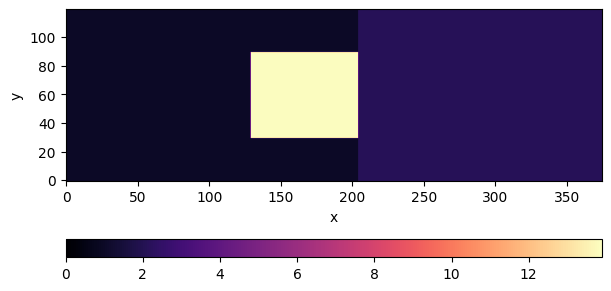

In [7]:
ceviche.viz.abs(epsr, cbar=True)
np.savetxt("saved_structures\\MT\\epsr_rect_Si_on_SiO2_F05.txt", epsr)
np.savetxt("saved_structures\\MT\\rho_rect_Si_on_SiO2_F05.txt", epsr)
np.savetxt("saved_structures\\MT\\drho_rect_Si_on_SiO2_F05.txt", epsr)

In [12]:
def J(x, y, omega, v, sigma_x, d):
    '''Electric current density'''

    j = -Q_e / (4*pi * d) / np.sqrt(2*pi* sigma_x **2) * np.exp(-(x*dl)**2/(2*sigma_x**2)) * np.exp(-1j * omega/v * (y*dl))
    
    return j


current = np.zeros((Nx, Ny), dtype=np.complex128)
for x in range(Nx):
    for y in range(Ny):
        current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)

<AxesSubplot:xlabel='x', ylabel='y'>

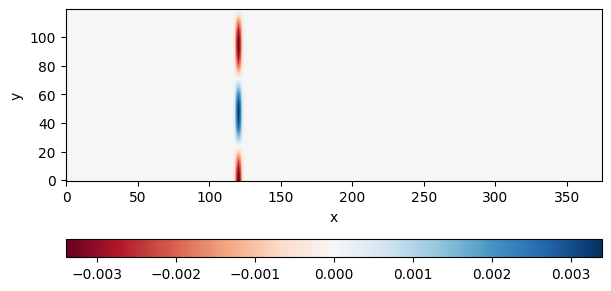

In [24]:
# ceviche.viz.abs(current, cbar=True)
ceviche.viz.real(current, cbar=True)

In [25]:
# Create the simulation object for 'Hz' (TM) polarization
simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])


source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
source_tmp[design_region == 1] = 0

In [26]:
# Run the simulation with the given source
Ex, Ey, Hz = simulation.solve(source_tmp)
Ey = Ey - current / (EPSILON_0 * 1j * omega)

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

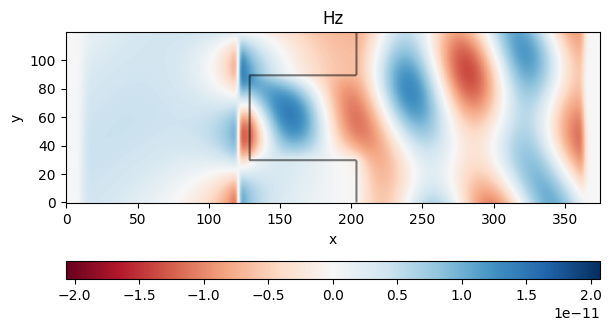

In [27]:
# Visualize the real value of the _ field component
# ceviche.viz.real(Ey, DK_title='Ey', outline=epsr, cbar=True)
ceviche.viz.real(Hz, DK_title='Hz', outline=epsr, cbar=True)

### Direct Design

In [705]:
# detector position
det_x = Nx - Npml - 20
print(f'detector position: X = {det_x}')


# the energy flux through the detector
def energy_flux(Sx, det_x):
    return npa.sum(Sx[det_x, :])/a

detector position: X = 261


In [706]:
def get_energy_flux(omega):
    '''The whole simulation in one function'''

    bloch_phase = -(omega/(beta*C_0)*a)
    simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, bloch_phase])
    current = np.zeros((Nx, Ny), dtype=np.complex128)

    for x in range(Nx):
        for y in range(Ny):
            current[x, y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)

    source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
    source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
    source_tmp[design_region == 1] = 0

    Ex, Ey, Hz = simulation.solve(source_tmp)
    Ey = Ey - current / (EPSILON_0 * 1j * omega)
    Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))

    return energy_flux(Sx, det_x)


In [707]:
# cross-check
energy_flux_CC = 9.807922844695182e-12
Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
energy_flux(Sx, det_x) / energy_flux_CC

0.8256426762829214

In [708]:
def get_total_energy_flux():
    total_flux = 0
    for omega in frequencies:
        total_flux += get_energy_flux(omega)

    return total_flux


In [709]:
def change_geometry(h, F):
    # Initialize relative permittivity of the domain
    epsr = np.ones((Nx, Ny))

    #################################################
    # grating for Smith-Purcell

    x1 = Npml + int((xL_PML + d) / dl)
    x2 = Npml + int((xL_PML + d + h) / dl)
    y1 = int(Ny/2*(1-F))
    y2 = int(Ny/2*(1-F) + F*Ny)
    epsr[x2:Nx, 0:y1]  = val_epsr_Si
    epsr[x1:Nx, y1:y2] = val_epsr_Si
    epsr[x2:Nx, y2:Ny] = val_epsr_Si

    return epsr

<AxesSubplot:xlabel='x', ylabel='y'>

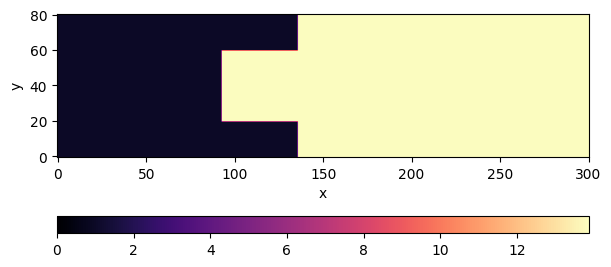

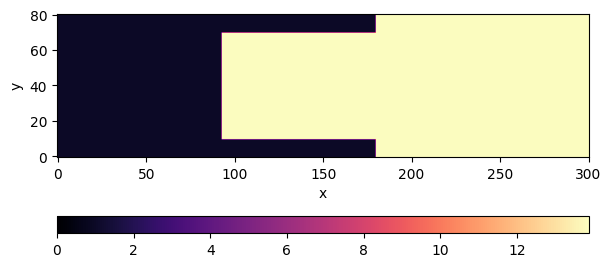

In [710]:
ceviche.viz.abs(change_geometry(h/2, 1/2), cbar=True)
ceviche.viz.abs(change_geometry(h, 0.75), cbar=True)

In [711]:
h_max = 300e-9
h_steps = 10
F_steps = 10

FH = np.zeros((h_steps+1, F_steps+1))

for nh, h in enumerate(np.arange(0, h_max + h_max/h_steps, h_max/h_steps)):
    for nF, F in enumerate(np.arange(0, 1 + 1/F_steps, 1/F_steps)):
        epsr = change_geometry(h, F)
        FH[nh, nF] = get_energy_flux(omega)

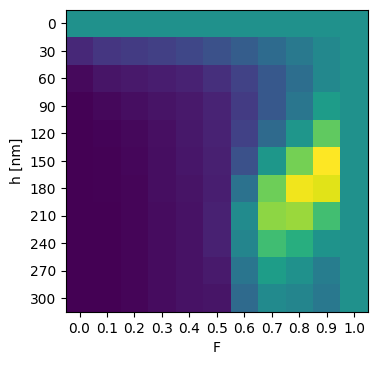

In [712]:
plt.imshow(FH)
plt.xlabel("F")
plt.ylabel("h [nm]")
x_ticks = ["{:.1f}".format(x) for x in np.arange(0, 1 + 1/F_steps, 1/F_steps)]
y_ticks = ["{:.0f}".format(x) for x in np.arange(0, h_max + h_max/h_steps, h_max/h_steps)*1e9]
plt.xticks(range(F_steps + 1), x_ticks);
plt.yticks(range(h_steps + 1), y_ticks);

plt.savefig("images\\29 Direct Design\\hF_optimization_5freq.png")